# Prelim Skills Exam

#### Objective(s):

Do the following using the CHEST x-rays dataset

[NIH Xrays](https://www.kaggle.com/datasets/nih-chest-xrays/data/data) to an external site.

1. Build and train a CNN model from a scratch.  Apply different regularization techniques and data preprocessing to reduce overfitting.

2.  Plot the training and validation loss and accuracy. The target accuracy is 85 and above.

3.  Use the assigned pre-trained model and fine-tuned it. 

4. Build and train a CNN model using the modified pretrained model.

5. Plot the training and validation loss and accuracy. The target accuracy is 95 and above.

6. Use the classification report, confusion matrix and ROC over AUC metric to evaluate also the performance of the scratch and using pre-trained mode

## Data Preprocessing

In [2]:
## Import necessary libraries
import numpy as np 
import pandas as pd 
import os
import cv2
from itertools import chain
from glob import glob
import gc

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('xray_data/Data_Entry_2017.csv',
                          skipinitialspace=True)

## Find all images in a folder
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('xray_data', 'images*', '*', '*.png'))}

## Check found images and row shape
len(all_image_paths), df.shape[0] 

(112120, 112120)

In [4]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [5]:
df['img_path'] = df['Image Index'].map(all_image_paths.get)
df.drop(columns='Unnamed: 11', inplace=True)
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],img_path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,xray_data\images_001\images\00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,xray_data\images_001\images\00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,xray_data\images_001\images\00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,xray_data\images_001\images\00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,xray_data\images_001\images\00000003_000.png


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  img_path                     112120 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 10.3+ MB


In [7]:
df.isna().sum()

Image Index                    0
Finding Labels                 0
Follow-up #                    0
Patient ID                     0
Patient Age                    0
Patient Gender                 0
View Position                  0
OriginalImage[Width            0
Height]                        0
OriginalImagePixelSpacing[x    0
y]                             0
img_path                       0
dtype: int64

In [8]:
df['Finding Labels'].value_counts()

Finding Labels
No Finding                                                         60361
Infiltration                                                        9547
Atelectasis                                                         4215
Effusion                                                            3955
Nodule                                                              2705
                                                                   ...  
Atelectasis|Consolidation|Edema|Effusion|Infiltration|Pneumonia        1
Atelectasis|Consolidation|Effusion|Emphysema|Mass|Pneumothorax         1
Cardiomegaly|Effusion|Pleural_Thickening|Pneumothorax                  1
Edema|Infiltration|Pneumothorax                                        1
Atelectasis|Consolidation|Mass|Pleural_Thickening|Pneumothorax         1
Name: count, Length: 836, dtype: int64

In [9]:
## Separates diseases from one another
labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
labels = [x for x in labels if len(x)>0]
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [10]:
## One hot encoding for the labels
for label in labels:
    df[label] = df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)
df.head(7)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Splitting Training set and Testing set

In [11]:
## Import Keras libraries

import keras
from keras import regularizers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D

In [12]:

datagen = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True,
                              rescale=1./255, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [13]:
split = int(df.shape[0]*.8) #take only 75% of the dataset
split

89696

In [14]:
train_data = df.iloc[:split, 11:]
test_data = df.iloc[split:, 11:]

(test_data.shape[0] + train_data.shape[0]) == df.shape[0] #check if split is accurate

True

## Model Training

In [15]:
## plot the graph
def plot_loss_accuracy(history, name):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('binary_cross_entropy loss')
    ax.grid(True)


    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history["binary_accuracy"],'r-x', label="Train Accuracy")
    ax.plot(history.history["val_binary_accuracy"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('binary_accuracy')
    ax.grid(True)
    
    plt.suptitle(name)

In [16]:
size = (224, 224)
batch = 150

train_set = datagen.flow_from_dataframe(
    directory=None,
    target_size=size,
    batch_size=batch,
    class_mode='raw',
    dataframe=train_data,
    x_col='img_path',
    y_col=list(train_data.columns[1:])
)

test_set = datagen.flow_from_dataframe(
    directory=None,
    target_size=size,
    batch_size=batch,
    class_mode='raw',
    dataframe=test_data,
    x_col='img_path',
    y_col=list(test_data.columns[1:])
)

Found 89696 validated image filenames.
Found 22424 validated image filenames.


In [18]:
## Create the model
model_1 = Sequential()

model_1.add(Conv2D(12, (5, 5), strides=(1, 1), padding='same',
                 input_shape=(224, 224, 3),
                 kernel_regularizer=regularizers.l2(0.001)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.5))

model_1.add(Conv2D(6, (3, 3), strides=(1, 1), padding='same',
                 kernel_regularizer=regularizers.l2(0.001)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.5))

model_1.add(Conv2D(6, (3, 3), strides=(1, 1), padding='same',
                 kernel_regularizer=regularizers.l2(0.001)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.5))

model_1.add(Flatten())

model_1.add(Dense(128))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))

model_1.add(Dense(len(labels)))
model_1.add(Activation('sigmoid'))

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 12)      912       
                                                                 
 activation_5 (Activation)   (None, 224, 224, 12)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 12)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 112, 112, 12)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 6)       654       
                                                                 
 activation_6 (Activation)   (None, 112, 112, 6)       0         
                                                      

In [20]:
gc.collect()

2186

In [21]:
model_1.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['binary_accuracy', 'accuracy'])

history_1 = model_1.fit(train_set,
              epochs=5,
              validation_data=test_set)

Epoch 1/5


NotFoundError: Graph execution error:

Detected at node 'gradient_tape/sequential_1/conv2d_4/Conv2D/Conv2DBackpropInput' defined at (most recent call last):
    File "c:\Users\Nil\miniconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Nil\miniconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 1077, in launch_instance
      app.start()
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 737, in start
      self.io_loop.start()
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Nil\miniconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\Nil\miniconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\Nil\miniconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue
      await self.process_one()
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 513, in process_one
      await dispatch(*args)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell
      await result
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 758, in execute_request
      reply_content = await reply_content
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 426, in do_execute
      res = shell.run_cell(
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Nil\AppData\Local\Temp\ipykernel_22980\3900732452.py", line 5, in <module>
      history_1 = model_1.fit(train_set,
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential_1/conv2d_4/Conv2D/Conv2DBackpropInput'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 117132688 bytes.
  Profiling failure on CUDNN engine 1: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 242571824 bytes.
  Profiling failure on CUDNN engine 0#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
	 [[{{node gradient_tape/sequential_1/conv2d_4/Conv2D/Conv2DBackpropInput}}]] [Op:__inference_train_function_2461]

In [ ]:
score_1 = model_1.evaluate(test_set)
print("Validation Loss: ", score_1[0])
print("Validation Accuracy: ", score_1[1])
gc.collect()

132/132 [==============================] - 300s 2s/step - loss: 0.2085 - binary_accuracy: 0.9277 - auc: 0.8674
Validation Loss:  0.20851950347423553
Validation Accuracy:  0.9276960492134094


4

#### Plotting the Loss and Accuracy

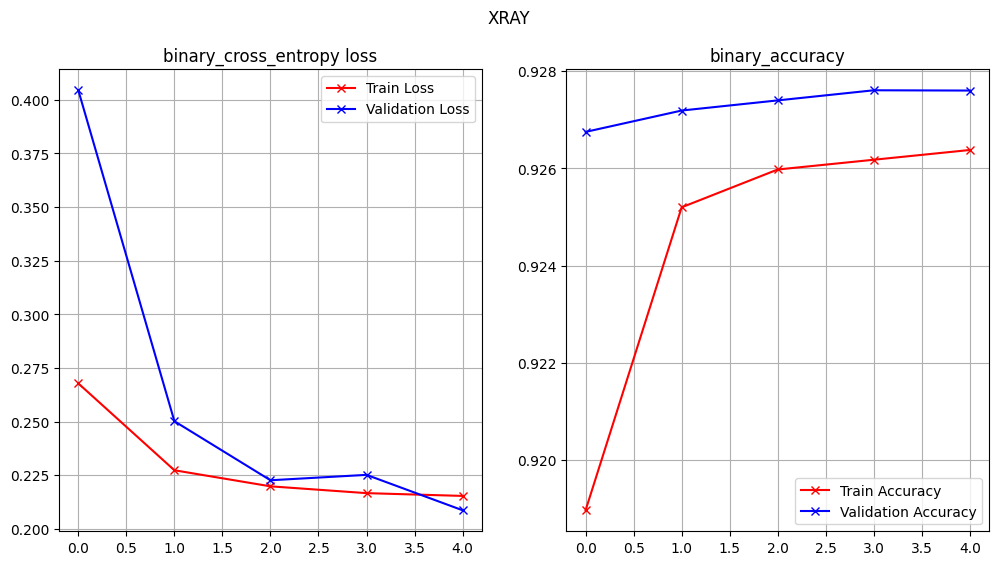

In [ ]:
plot_loss_accuracy(history, 'XRAY')

#### Using a pre-trained model

In [ ]:
from keras.applications import mobilenet_v2

preTrained_model = mobilenet_v2.MobileNetV2(input_shape=(224,224,3),
                                             include_top=False)

model_2 = Sequential()
model_2.add(preTrained_model)
model_2.add(GlobalAveragePooling2D())
model_2.add(Dropout(0.5))

model_2.add(Dense(128))
model_2.add(Dropout(0.5))
model_2.add(Dense(len(labels)))
model_2.add(Activation('sigmoid'))

model_2.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_8   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_29 (Dropout)        (None, 1280)              0         
                                                                 
 dense_26 (Dense)            (None, 128)               163968    
                                                                 
 dropout_30 (Dropout)        (None, 128)               0         
                                                                 
 dense_27 (Dense)            (None, 15)              

In [ ]:
gc.collect()

7485

In [ ]:
model_2.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['binary_accuracy', 'accuracy'])

history_2 = model_2.fit(train_set,
              epochs=1,
              validation_data=test_set)

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_18/mobilenetv2_1.00_224/bn_Conv1/FusedBatchNormV3' defined at (most recent call last):
    File "c:\Users\Nil\miniconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Nil\miniconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 1077, in launch_instance
      app.start()
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 737, in start
      self.io_loop.start()
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Nil\miniconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\Nil\miniconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\Nil\miniconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue
      await self.process_one()
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 513, in process_one
      await dispatch(*args)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell
      await result
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 758, in execute_request
      reply_content = await reply_content
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 426, in do_execute
      res = shell.run_cell(
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Nil\AppData\Local\Temp\ipykernel_14180\3494876288.py", line 5, in <module>
      history_2 = model_2.fit(train_set,
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "c:\Users\Nil\miniconda3\envs\tf\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 634, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'sequential_18/mobilenetv2_1.00_224/bn_Conv1/FusedBatchNormV3'
OOM when allocating tensor with shape[250,32,112,112] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_18/mobilenetv2_1.00_224/bn_Conv1/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_69822]

In [ ]:
'''
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
base_mobilenet_model = MobileNet(input_shape =  t_x.shape[1:], 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()


from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]




'''